<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrame API

`dask.dataframe` API is the high-level collection that looks and feels like the pandas API, but for parallel and distributed workflows. At it's core, the `dask.dataframe` module implements a blocked parallel `DataFrame` object that. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrame`s separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     width="30%"
     alt="Dask DataFrame is compsed of pandas DataFrames"/>

The term "Dask DataFrame" is slightly overloaded. Depending on the context, it can refer to the API or the DataFrame object (data structure composed on multiple pandas DataFrames shown above). To avoid confusion, throughout this notebook:
- `dask.dataframe` (note the all lowercase) refers to the API, and
- `dask.dataframe.DataFrame` or simply `DataFrame` (note the CamelCase) refers to the object.

## When to use `dask.dataframe`

pandas is great for tabular datasets that fit in memory. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Dask becomes useful when the datasets exceed the above rule.

In this notebook, you will be working with the New York City Airline data. This dataset is only 200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets **much** larger than memory. If you can store the data locally on your hard-drive, you can use Dask to analyze it.

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

## Create datasets

Create the datasets you will be using in this notebook:

In [2]:
%run prep.py -d flights

## Set up your local cluster

Create a local Dask cluster and connect it to the client. Don't worry about this bit of code for now, you will learn more in the Distributed notebook.

In [3]:
from dask.distributed import Client

client = Client(n_workers=4)
client

2022-07-05 19:51:31,912 - bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54822,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54846,Total threads: 2
Dashboard: http://127.0.0.1:54847/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54826,


### Dask Diagnostic Dashboard

Dask Distributed provides a useful Dashboard to visualize the state of your cluster and computations.

If you're on **JupyterLab or Binder**, you can use the [Dask JupyterLab extension](https://github.com/dask/dask-labextension) (which should be already installed in your environment) to open the dashboard plots:
* Click on the Dask logo in the left sidebar
* Click on the magnifying glass icon, which will automatically connect to the active dashboard (if that doesn't work, you can type/paste the dashboard link http://127.0.0.1:8787 in the field)
* Click on **"Task Stream"**, **"Progress Bar"**, and **"Worker Memory"**, which will open these plots in new tabs
* Re-organize the tabs to suit your workflow!

Alternatively, click on the dashboard link displayed in the Client details above: http://127.0.0.1:8787/status. It will open a new browser tab with the Dashboard.

## Reading and working with datasets

Let's read an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

The following filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same Dask `DataFrame`.

In [5]:
import os
import dask

filename = os.path.join('data', 'nycflights', '*.csv')
filename

'data/nycflights/*.csv'

By convention, we import `dask.dataframe` as `dd`, and call the corresponding Dask DataFrame `ddf`.

In [6]:
import dask.dataframe as dd

In [7]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                  parse_dates={'Date': [0, 1, 2]})

In [8]:
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has not loaded the data yet, it has:
- investigated the input path and found that there are three matching files
- intelligently created a set of jobs for each chunk -- one per original CSV file in this case

Notice that the representation of the DataFrame object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

### Lazy Evaluation

Most Dask Collections, including Dask `DataFrame` are evaluated lazily, which means Dask constructs the logic (called task graph) of your computation immediately but "evaluates" them  only when necessary.

You will learn more about this in the Delayed notebook, but for now, note that we need to call `.compute()` to trigger actual computations.

Some functions like `len` and `head` also trigger a computation. Specifically, calling `len` will:
- load actual data, (that is, load each file into a pandas DataFrame)
- then apply the corresponding functions to each pandas DataFrame (also known as a partition)
- combine the subtotals to give you the final grand total

In [9]:
# load and count number of rows
len(ddf)

2611892

You can view the start and end of the data as you would in pandas:

In [10]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [11]:
# ddf.tail()

# this fails with:
#
# ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

# +----------------+---------+----------+
# | Column         | Found   | Expected |
# +----------------+---------+----------+
# | CRSElapsedTime | float64 | int64    |
# | TailNum        | object  | float64  |
# +----------------+---------+----------+

# The following columns also raised exceptions on conversion:

# - TailNum
#   ValueError("could not convert string to float: 'N54711'")

# Usually this is due to dask's dtype inference failing, and
# *may* be fixed by specifying dtypes manually by adding:

# dtype={'CRSElapsedTime': 'float64',
#        'TailNum': 'object'}

# to the call to `read_csv`/`read_table`.


Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

In [12]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [13]:
ddf.tail()  # now works

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### Reading from remote storage

If you're thinking about distributed computing, your data is probably stored remotely on services (like Amazon's S3 or Google's cloud storage) and is in a friendlier format (like Parquet). Dask can read data in various formats directly from these remote locations **lazily** and **in parallel**.

Here's how you can read the NYC taxi cab data from Amazon S3:

```python
ddf = dd.read_parquet(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.parquet",
)
```

You can also leverage Parquet-specific optimizations like column selection and metadata handling, learn more in [the Dask documentation on working with Parquet files](https://docs.dask.org/en/stable/dataframe-parquet.html).

## Computations with `dask.dataframe`

Let's compute the maximum of the `DepDelay` column.

With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

`dask.dataframe` lets us write pandas-like code, that operates on larger-than-memory datasets in parallel.

In [14]:
%%time
ddf.DepDelay.max().compute()

CPU times: user 70.3 ms, sys: 15.7 ms, total: 86 ms
Wall time: 1.09 s


1435.0

This creates the lazy computation for us and then runs it.  

**Note:** Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. This means you can handle datasets that are larger than memory but, repeated computations will have to load all of the data in each time. (Run the code above again, is it faster or slower than you would expect?)

You can view the underlying task graph using the `.visualize` method:

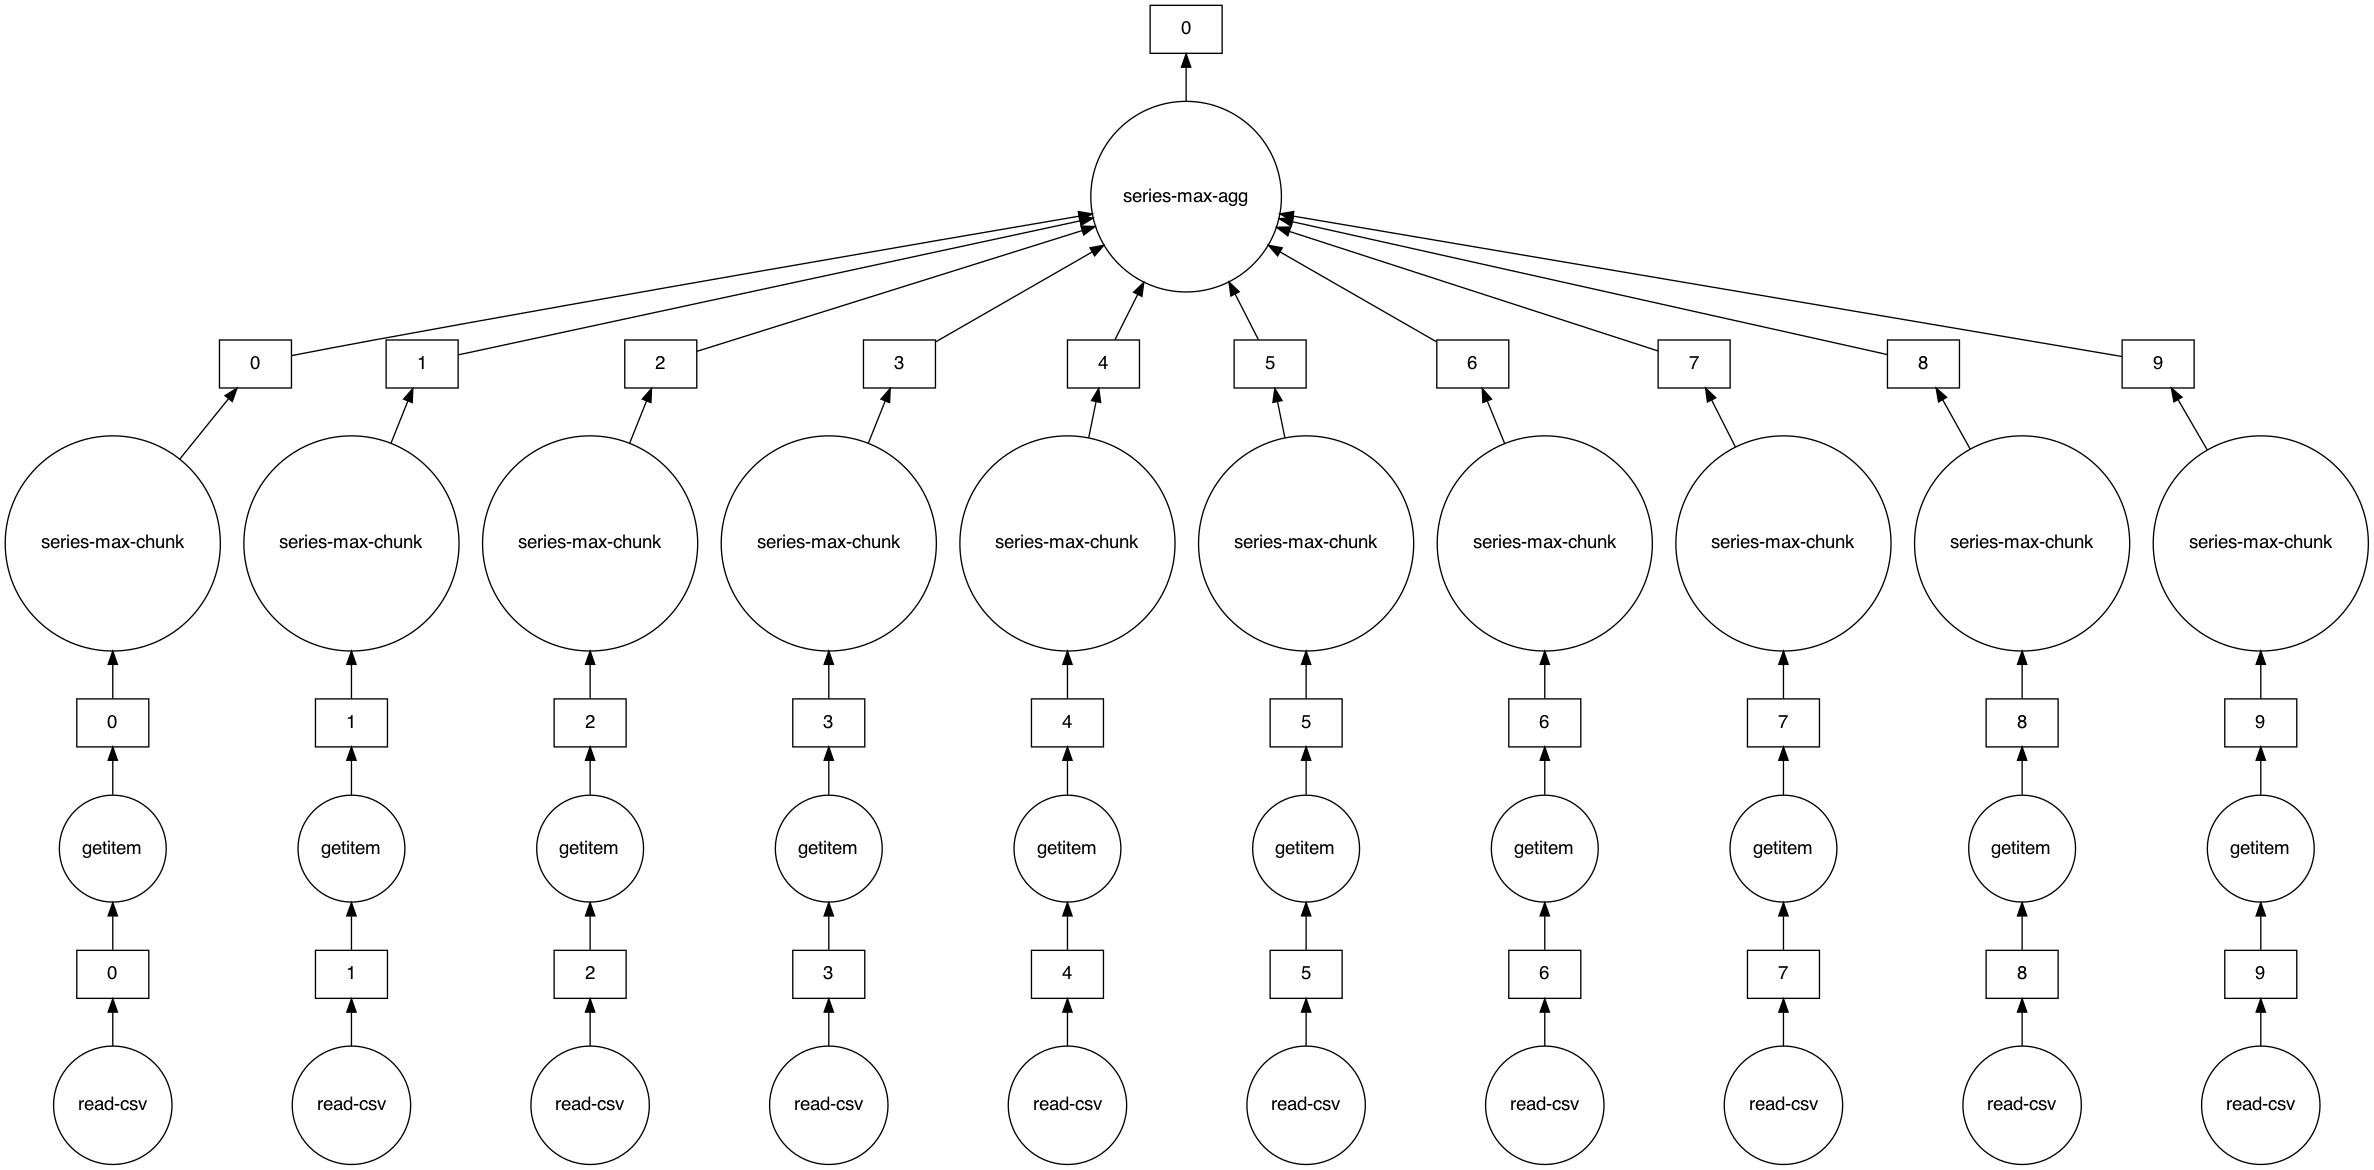

In [15]:
# notice the parallelism
ddf.DepDelay.max().visualize()

## Exercises

In this section you will do a few `dask.dataframe` computations. If you are comfortable with pandas then these should be familiar. You will have to think about when to call `compute`.

### 1. How many rows are in our dataset?

If you aren't familiar with pandas, how would you check how many records are in a list of tuples?

In [16]:
# Your code here

In [17]:
len(ddf)

2611892

### 2. In total, how many non-canceled flights were taken?

With pandas, you would use [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [18]:
# Your code here

In [19]:
len(ddf[~ddf.Cancelled])

2540961

### 3. In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [20]:
# Your code here

In [21]:
ddf[~ddf.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### 4. What was the average departure delay from each airport?

In [22]:
# Your code here

In [23]:
ddf.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### 5. What day of the week has the worst average departure delay?

In [24]:
# Your code here

In [25]:
ddf.groupby("DayOfWeek").DepDelay.mean().idxmax().compute()

5

### 6. Let's say the distance column is erroneous and you need to add 1 to all values, how would you do this?

In [ ]:
# Your code here

In [47]:
ddf["Distance"].apply(lambda x: x+1).compute() # don't worry about the warning, we'll discuss in the next sections

/Users/pavithra/mambaforge/envs/dask-tutorial/lib/python3.9/site-packages/dask/dataframe/core.py:3974: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Distance', 'float64'))

  warnings.warn(meta_warning(meta))


0          320.0
1          320.0
2          320.0
3          320.0
4          320.0
           ...  
269176    1620.0
269177    1620.0
269178    1620.0
269179    1620.0
269180    1620.0
Name: Distance, Length: 2611892, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If you compute them with two calls to compute, there is no sharing of intermediate computations.

In [26]:
non_cancelled = ddf[~ddf.Cancelled]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [20]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 194 ms, sys: 73 ms, total: 267 ms
Wall time: 2.26 s


### `dask.compute`

But let's try by passing both to a single `compute` call.

In [31]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 88.4 ms, sys: 14.8 ms, total: 103 ms
Wall time: 1.23 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (you might want to use `filename='graph.pdf'` to save the graph to disk so that you can zoom in more easily):

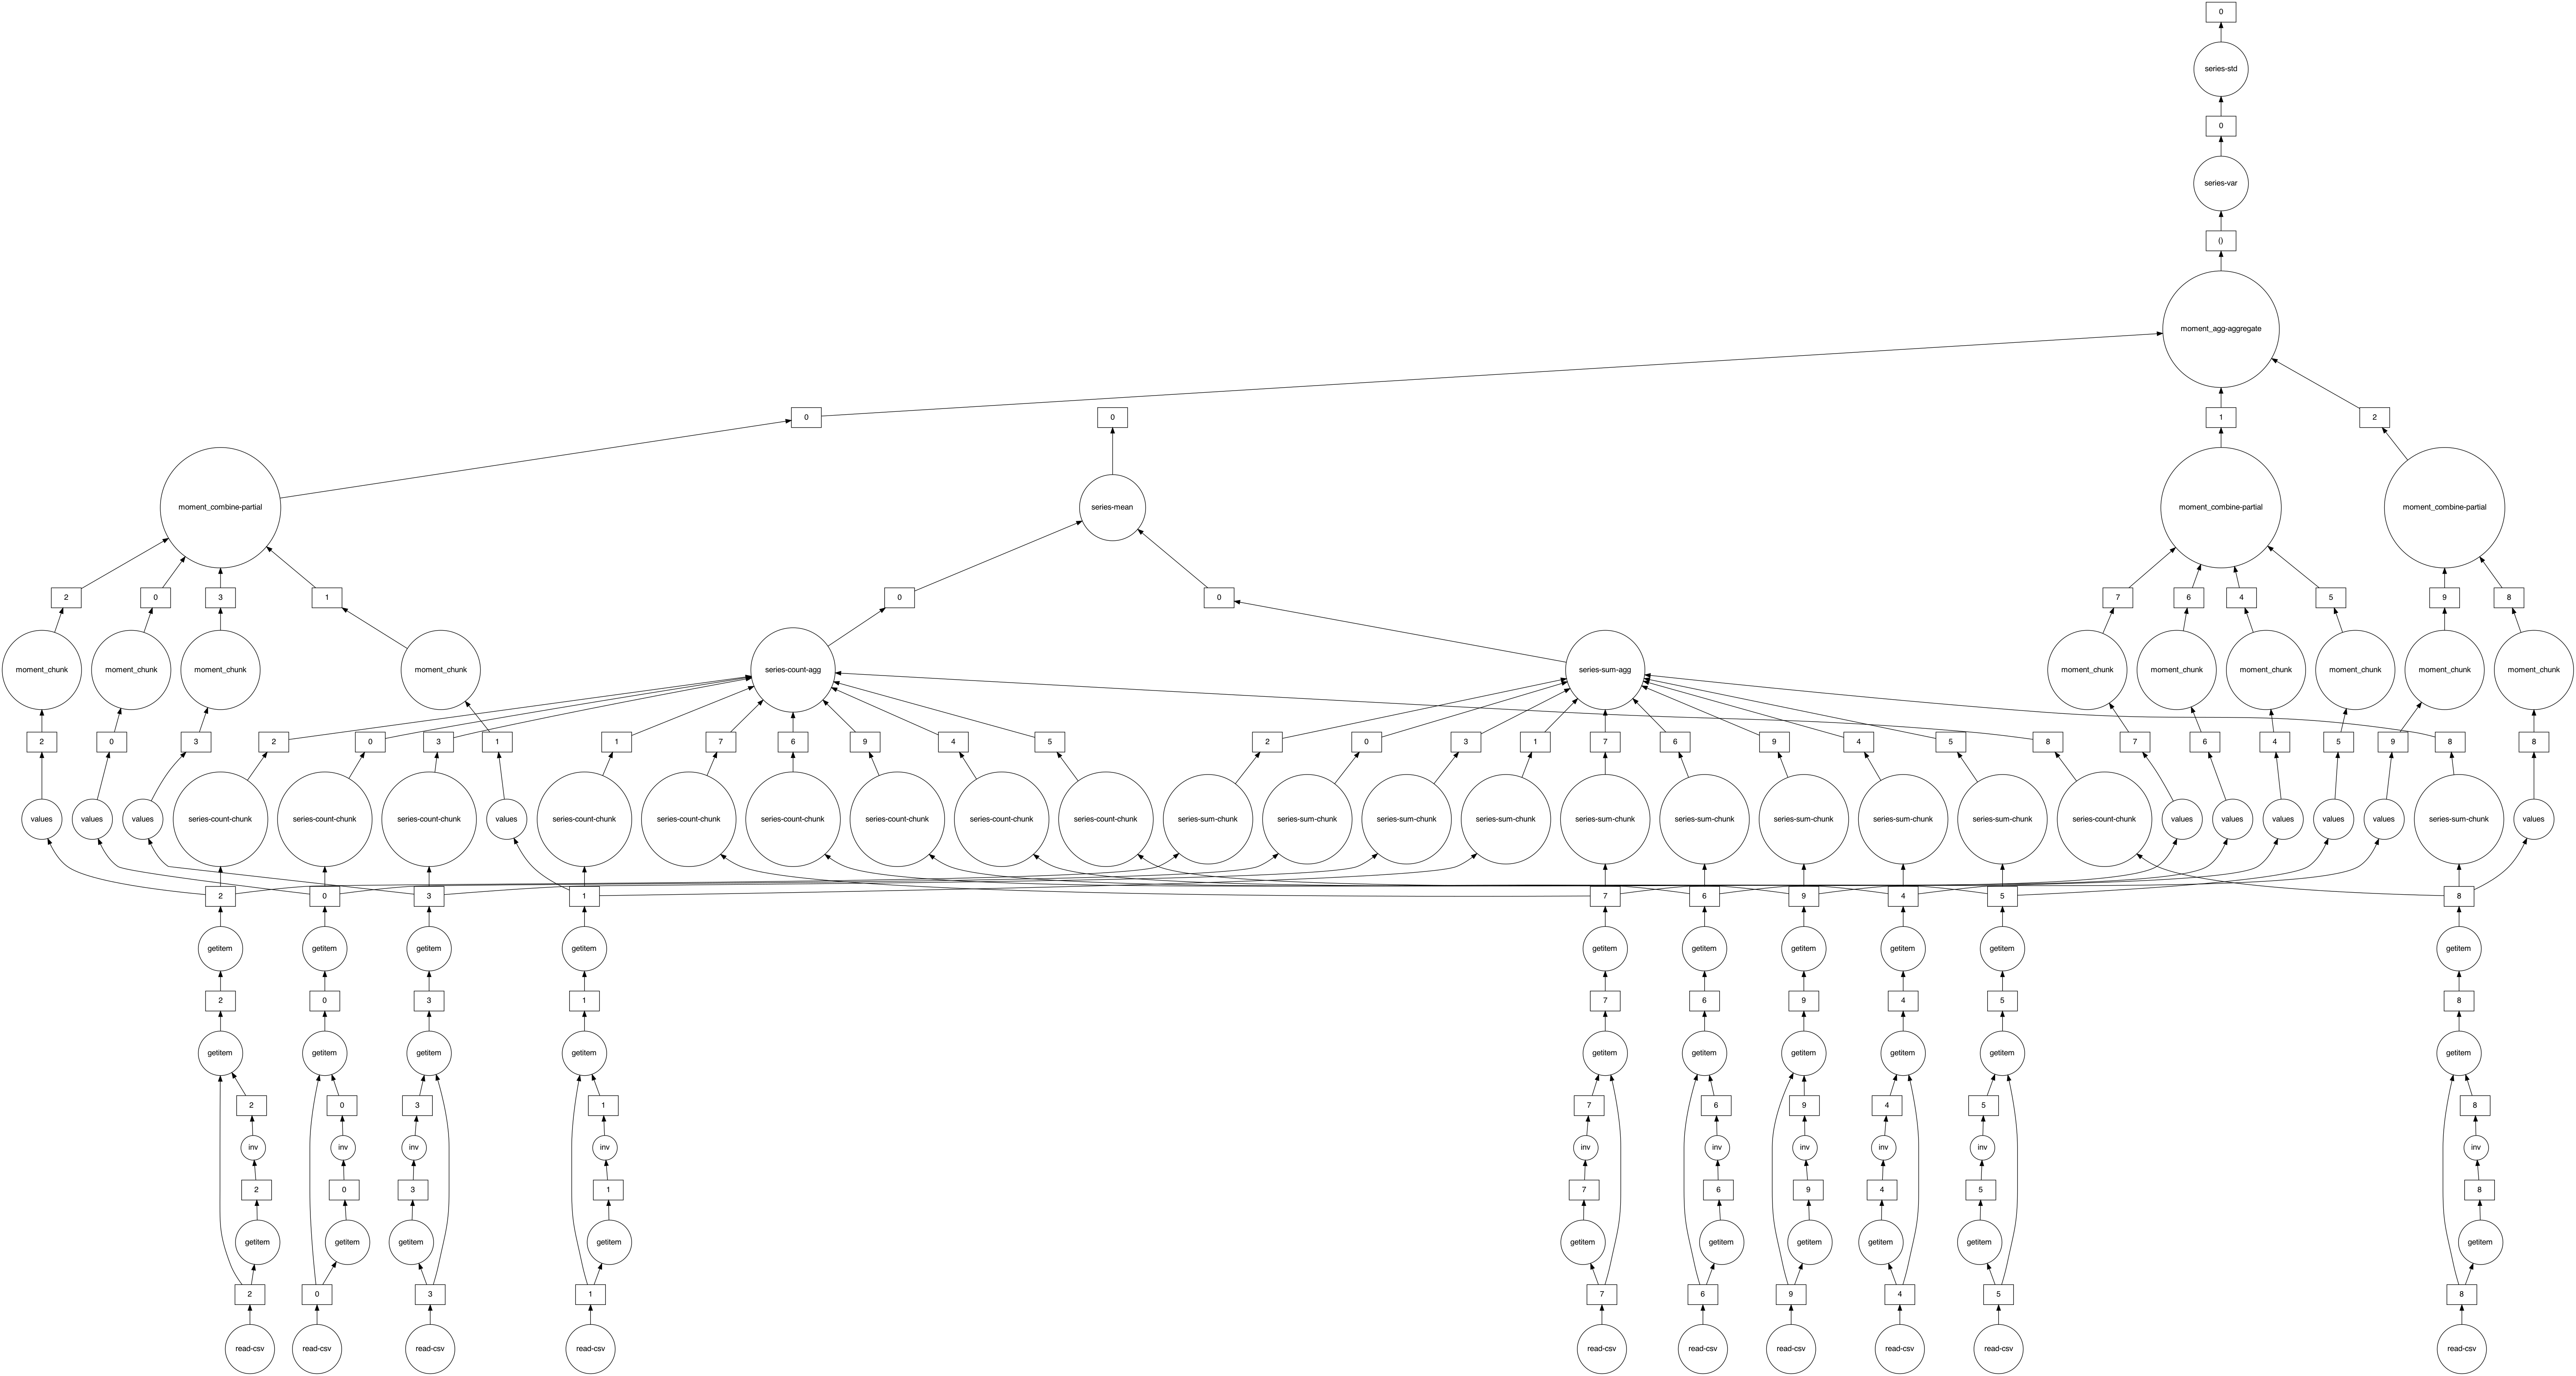

In [32]:
dask.visualize(mean_delay, std_delay)

### `persit`

While using a distributed scheduler (you will learn more about schedulers in the upcoming notebooks), which is the case in this notebook, you can keep some _data that you want to use often_ in the _distributed memory_. 

`persist` computes the "Futures" ( and stores it in the same structure as your output. You can use persist with any data or computation that fits in memory.

**Note:**
1. Using `persist` with "single-machine" schedulers just triggers an immediate computation, like `compute`. Hence, it's used only in distributed scenarios.
2. Make sure to only persist small datasets that can fit comfortably in memory.

If you want to analyze data only for non-canceled flights departing from JFK airport, you can either have two compute calls like in the previous section:

In [41]:
non_cancelled = ddf[~ddf.Cancelled]
ddf_jfk = non_cancelled[non_cancelled.Origin == "JFK"]

In [42]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: user 193 ms, sys: 37.6 ms, total: 231 ms
Wall time: 2.38 s


4422520.0

Or, consider persisting that subset of data in memory.

See the "Graph" dashboard plot, the red squares indicate persisted data stored as Futures in memory. You will also notice an increase in Worker Memory (another dashboard plot) consumption.

In [43]:
ddf_jfk = ddf_jfk.persist() # returns back control immediately

In [44]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

CPU times: user 99 ms, sys: 18 ms, total: 117 ms
Wall time: 862 ms


31.24250979827115

Analyses on this persisted data is faster because we are not repeating the loading and selecting (non-canceled, JFK departure) operations.

## How does this compare to pandas?

pandas is more mature and fully featured than `dask.dataframe`. If your data fits in memory then you should use pandas. The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial you used a small dataset consisting of a few CSV files. This dataset is 45MB on disk that expands to about 400MB in memory. This dataset is small enough that you would normally use pandas.

We've chosen this size so that exercises finish quickly. `dask.dataframe` only really becomes meaningful for problems significantly larger than this, when pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler (you will learn about it later) allows the same `dask.dataframe` expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

`dask.dataframe` operations use `pandas` operations internally.  Generally, they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task. This is usually negligible.
2.  When pandas releases the GIL `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

## Custom code with Dask DataFrame

Example: Converting `CRSDepTime` to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [ ]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [ ]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

We could swap out `pd.to_timedelta` for `dd.to_timedelta` and do the same operations on the entire Dask DataFrame. But let's say that Dask hadn't implemented a `dd.to_timedelta` that works on Dask DataFrames. What would you do then?

`dask.dataframe` provides a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timedelta` on our own:

In [ ]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

The basic idea is to apply a function that operates on a DataFrame to each partition.
In this case, we'll apply `pd.to_timedelta`.

In [ ]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [ ]:
departure_timestamp

In [ ]:
departure_timestamp.head()

### Exercise: Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [ ]:
def compute_departure_timestamp(df):
    pass  # TODO: implement this

In [ ]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

departure_timestamp.head()

In [ ]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

In [15]:
client.shutdown()

2022-05-25 19:26:23,860 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## Final thoughts

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.